# Generating the Milky Way potential using McMillan's standalone GalPot and its python wrapper

We compare the best model from McMillan (2017, henceforth PJM17) with and without central hole, 
and create tables for the gravitational potential that can be read by our PLUTO code setup.

We also plot the density, surface density, enclosed mass profiles, and rotation curves.

In [122]:
# Some helpful imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

import mpl_aesth
mpl_aesth.adjust_rcParams('seaborn', True, False)

import norm
import physconst as pc
nm = norm.PhysNorm(m=pc.msun, x=pc.kpc, t=pc.Myr, temp=1., curr=1.)

Import GalaxyPotential class

In [123]:
from GalPot import GalaxyPotential

## Calculating the potential

Load the potential file

In [124]:
Phi = GalaxyPotential("pot/PJM17_best.Tpot")
Phi_nh = GalaxyPotential("pot/PJM17_best_nohole.Tpot")
vconv = Phi.kpc_Myr_to_km_s
phi_plt_norm = vconv ** 2 / 1.e5

> Note: All the internal workings are in units M<sub>sun</sub>, kpc, Myr (as in the C++ code).
Conversions for velocities can be applied with the helpful GalaxyPotential value kpc_Myr_to_km_s (=977.77)


The domain

In [125]:
R_min, R_max, nR = 0.1, 10, 100
z_min, z_max, nz = 0.1, 10, 100
R = np.linspace(0.1, 10, nR)
z = np.linspace(0.1, 10, nz)
RR, zz = np.meshgrid(R, z)
RR, zz = RR.ravel(), zz.ravel()
R0, z0 = np.zeros_like(R), np.zeros_like(z)

Find potential

In [126]:
# Find Potential
phi = Phi.Potential(R, z)
phi_nh = Phi.Potential(R, z)

## Potential as functions of R and z

### Potential of R along z = 0, and potential of z along R = 0.

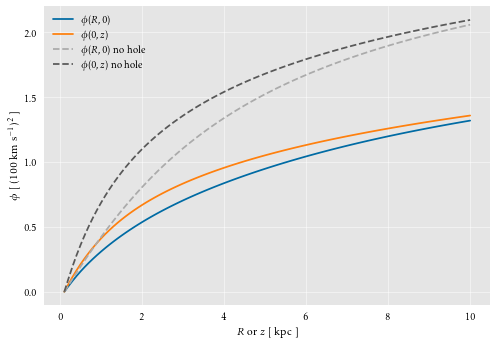

In [127]:
pot_r = Phi.Potential(R, z0) * phi_plt_norm
pot_z = Phi.Potential(R0, z) * phi_plt_norm
pot_r_nh = Phi_nh.Potential(R, z0) * phi_plt_norm
pot_z_nh = Phi_nh.Potential(R0, z) * phi_plt_norm
pot_r -= pot_r[0]
pot_z -= pot_z[0]
pot_r_nh -= pot_r_nh[0]
pot_z_nh -= pot_z_nh[0]
plt.plot(R, pot_r, label=r'$\phi(R, 0)$')
plt.plot(z, pot_z, label=r'$\phi(0, z)$')
plt.plot(R, pot_r_nh, '--', label=r'$\phi(R, 0)$ no hole')
plt.plot(z, pot_z_nh, '--', label=r'$\phi(0, z)$ no hole')
plt.xlabel(r'$R$ or $z$ [ kpc ]')
plt.ylabel(r'$\phi$ [ (100 km s$^{-1}$)$^2$ ]')
plt.legend()
plt.show()

### Two-dimensional potential 

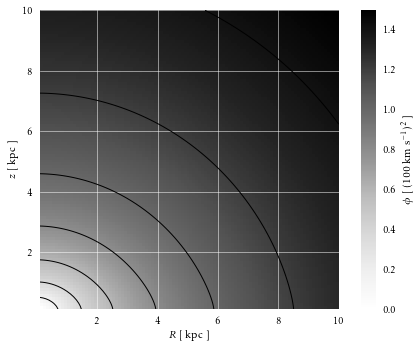

In [128]:
pot_2d = Phi.Potential(RR, zz).reshape(nR, nz) * phi_plt_norm
pot_2d -= pot_2d[0, 0]

plt.imshow(pot_2d, origin='lower', extent=[R_min, R_max, z_min, z_max])
plt.gca().set_aspect('equal')
plt.colorbar(label=r'$\phi$ [ (100 km s$^{-1}$)$^2$ ]')
plt.contour(R, z, pot_2d, colors='k', linewidths=1)
plt.xlabel(r'$R$ [ kpc ]')
plt.ylabel(r'$z$ [ kpc ]')
plt.show()

## Derivatives wrt R & z of potential

In [129]:
dphidr = Phi.Potential_derivatives(RR, zz)

## Density as functions of R and z

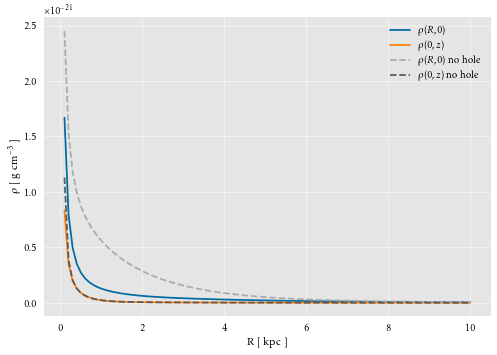

In [130]:
plt.plot(R, Phi.Density(R, z0) * nm.dens, label=r'$\rho(R, 0)$')
plt.plot(R, Phi.Density(R0, z) * nm.dens, label=r'$\rho(0, z)$')
plt.plot(R, Phi_nh.Density(R, z0) * nm.dens, '--', label=r'$\rho(R, 0)$ no hole')
plt.plot(R, Phi_nh.Density(R0, z) * nm.dens, '--', label=r'$\rho(0, z)$ no hole')
plt.xlabel('R [ kpc ]')
plt.ylabel(r'$\rho$ [ g cm$^{-3}$ ]')
plt.legend()
plt.show()

## Enclosed mass as a function of spherical radius

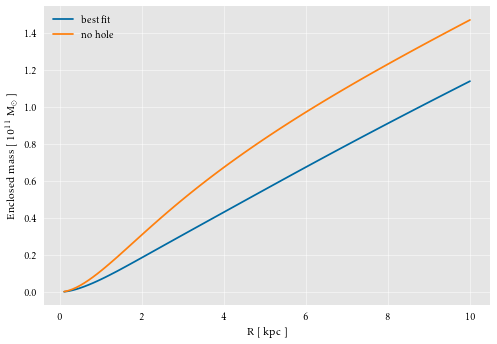

In [131]:
plt.plot(R, Phi.Mass(R) / 1.e11, label='best fit')
plt.plot(R, Phi_nh.Mass(R) / 1.e11, label='no hole')
plt.xlabel('R [ kpc ]')
plt.ylabel(r'Enclosed mass [ 10$^{11}$ M$_\odot$ ]')
plt.legend()
plt.show()

## Rotation curve

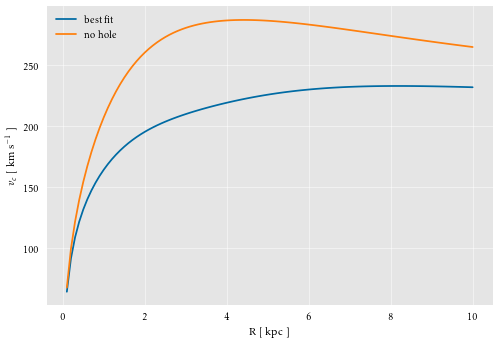

In [132]:
plt.plot(R, Phi.Vcirc(R) * vconv, label='best fit')
plt.plot(R, Phi_nh.Vcirc(R) * vconv, label='no hole')
plt.xlabel('R [ kpc ]')
plt.ylabel(r'$v_c$ [ km s$^{-1}$ ]')
plt.legend()
plt.show()
